# Displaying Data with JKSets

This notebook is written to give some examples of the ways in which hera_stats can be used to display jackknife data or any data.

Duncan Rocha, July 2018

In [1]:
%matplotlib inline
import hera_stats as hs
from hera_stats.data import DATA_PATH
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Load container with data and peek into it
fpath = os.path.join(DATA_PATH, "jack_data.h5")
pc = hs.PSpecContainer(fpath)
hs.jkset.peek(pc)

spl_ants:
   shape: (5, 2)
spl_gha:
   shape: (2, 3)
stripe_times:
   shape: (4, 2)


In [3]:
# Load jkset
jk = hs.JKSet(pc, "spl_ants")
jk

<hera_stats.jkset.JKSet instance at 0x1043822d0>

Jackknife Data
--------------
jktype: spl_ants
data shape: (5, 2)

In [4]:
jk.grps[0]

array([['39', '53', '54', '51', '68'],
       ['38', '52', '67', '69', '37']], dtype='|S21')

Group 0: [38 39 51 53 69]
Group 1: [37 52 54 67 68]


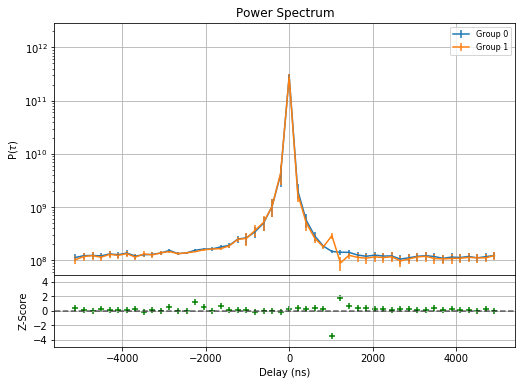

In [5]:
# Plot second jackknife group
hs.plots.plot_spectra(jk[1], z_method="varsum")
for i, g in enumerate(jk[1].grps):
    print "Group %i: %s" % (i, np.asarray(sorted(g), dtype=int))

For two points $x_1$ and $x_2$, with error bars $\sigma_1$ and $\sigma_2$ respectively, we can calculate the zscore using the sum of variances. Note that the for a sum of variances, the number of data points is halved.

$\sigma_c = \sqrt{\sigma_1^2 + \sigma_2^2}$

$z = (x_1 - x_2)/\sigma_c$

For n point $\{x_1, x_2, ..., x_n\}$, with error bars $\{\sigma_1, \sigma_2, ..., \sigma_n\}$, we can calcuate error bars using a weighted average. For this, the number of data points is conserved.

$ \sigma_{\bar{x}} = \big(\sum \frac{1}{\sigma_i^2}\big)^{-1}$

$ \bar{x} = \sigma_{\bar{x}} \sum x_i \sigma_i^{-2}$

$ \sigma_{x} \approx \sqrt{\sigma_\bar{x} n} $

And the zscore for a given $x_i$ is

$z_i = (x_i - \bar{x}) / \sigma_x $

(5,) (5,)


Text(0.5,1,'Jackknife Data (Weighted Sum)')

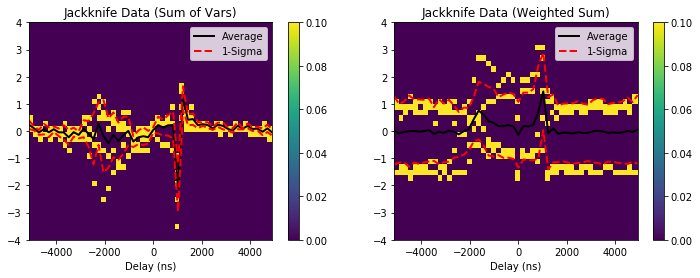

In [6]:
# Calculate zscores. To keep the same number of data points in zvar and zwgt,
# I use the half of the data points for weightedsum.
zvar = hs.stats.zscores(jk, axis=1, z_method="varsum")
zwgt = hs.stats.zscores(jk[:, 0],z_method="weightedsum")

print zvar.shape, zwgt.shape

f = plt.figure(figsize=(12,4))

# Plot hist_2d using sum of variances method
ax = f.add_subplot(121)
hs.plots.hist_2d(zvar, ax=ax, logscale=False, ylim=(-4,4), normalize=True, vmax=0.1)
ax.set_title("Jackknife Data (Sum of Vars)")

# Plot hist_2d using weighted sum method
ax = f.add_subplot(122)
hs.plots.hist_2d(zwgt, ax=ax, logscale=False, ylim=(-4,4), normalize=True, vmax=0.1)
ax.set_title("Jackknife Data (Weighted Sum)")

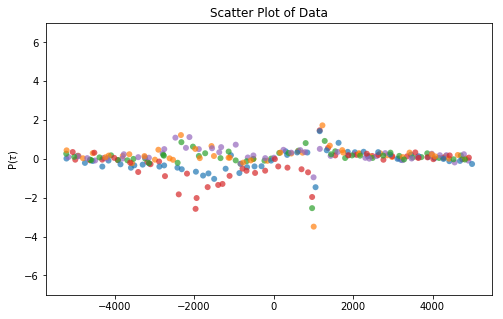

In [7]:
# A scatterplot is another way of showing the distribution of the data
hs.plots.scatter(zvar, logscale=False, ylim=(-6,6))

There is definitely some movement inside the peak of the power spectra that cannot be attributed to random fluctionations within the error bars! To be robust though, it would be great if we could run a statistical test, by delay mode, on the data. Oh wait, we can! One example is a KS-Test, which can be used to compare a data sample to a specific distribution. In the following cell, we run a kstest on both the sum of variance zscores and the weighted sum zscores.

If the pvalue is above the KS Statistic, the sample passes and the null hypothesis (that the data was sampled from a (0, 1) gaussian) cannot be rejected. Thus, the data fails the ks test extremely poorly in the middle (as expected) and passes on the wings.

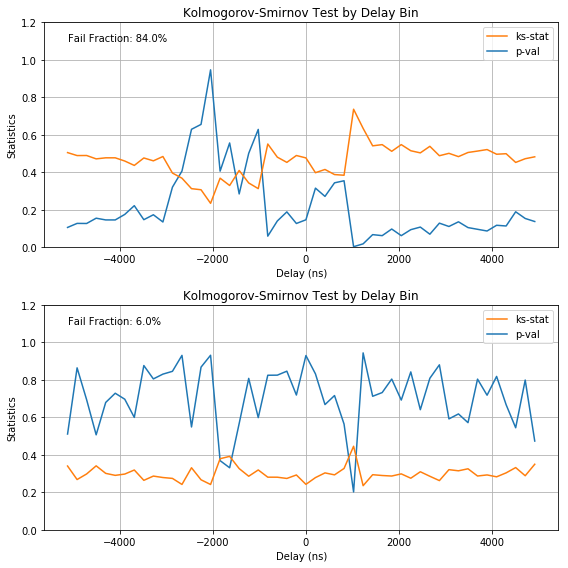

In [8]:
# KSTest using median standard deviation of zscores
f = plt.figure(figsize=(8, 8))

# Create cumulative distribution function
import scipy.stats as spstats
cdf = spstats.norm(0, 1.5).cdf

# Plot kstest for sum of variances
ax = f.add_subplot(211)
hs.plots.plot_kstest(zvar, ax=ax, cdf=cdf)

# Plot kstest for weighted sum method
ax2 = f.add_subplot(212)
hs.plots.plot_kstest(zwgt, ax=ax2, cdf=cdf)

f.tight_layout()

Another test we can run is an Anderson-Darling test. This tests only normality of a sample, not the specfic distribution. If the data is distributed normally, One would expect the failure rates for each significance level to match the significance level. As you can see, it doesn't perform all that well.

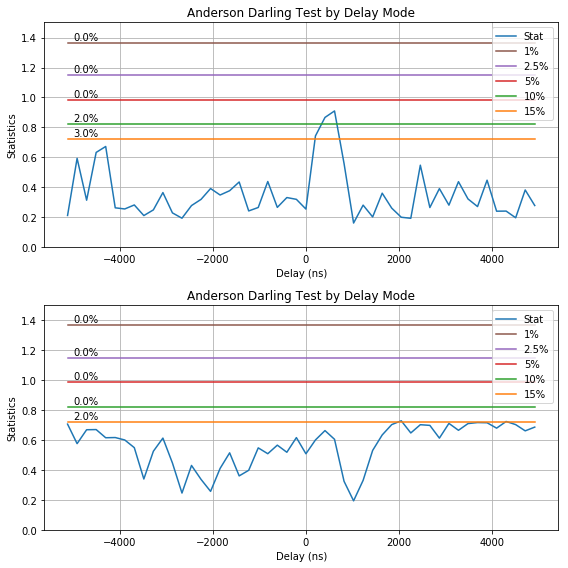

In [9]:
# Anderson test with two zscore types
f = plt.figure(figsize=(8, 8))

ax = f.add_subplot(211)
hs.plots.plot_anderson(zvar, ax=ax)

ax2 = f.add_subplot(212)
hs.plots.plot_anderson(zwgt, ax=ax2)

f.tight_layout()

One more example, of how one might use the data in an application that is not specifically found in hera_stats. If we wanted to compare zscore histograms inside and outside the peak, we could index zwgt accordingly and plot the histogram with matplotlib. And we see that inside the peak, the data is much more widely distributed than outside.

In [ ]:
del psc

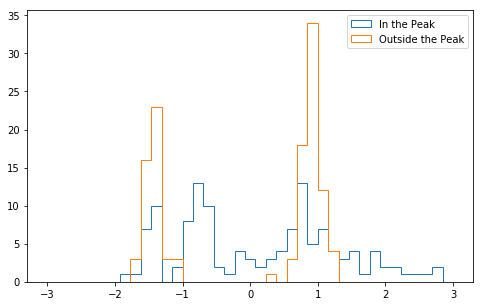

In [10]:
f = plt.figure(figsize= (8, 5))
ax = f.add_subplot(111)

ndlys = len(jk.dlys)
q1 = ndlys // 4
q2 = ndlys - q1

wings = np.arange(-q1, q1, 1) % ndlys
center = np.arange(q1, q2, 1)

bins = np.linspace(-q1/4, q1/4, 40)

# Plot delay modes 25-75 (the [peak])
h1 = ax.hist(zwgt.spectra[:, center].flatten(), bins=bins, histtype="step")

# Plot delay modes 0-25 and 75-100.
h2 = ax.hist(zwgt.spectra[:, wings].flatten(), bins=bins, histtype="step")

ax.legend(labels = ["In the Peak", "Outside the Peak"])
pass